In [0]:
print("🎯 DAY 4")
print("="*60)

# 1. Import
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import pandas as pd
import numpy as np

print("✅ Libraries imported")

🎯 DAY 4
✅ Libraries imported


### 2. Load data

In [0]:
print("\n1️⃣ Loading customer data...")
gold_df = spark.table("brazil_project.gold.ml_customer_features").toPandas()
print(f"   Loaded {len(gold_df)} customers")


1️⃣ Loading customer data...
   Loaded 98666 customers


### 3. CREATE CHURN LABEL

In [0]:
print("\n2️⃣ Creating churn label INDEPENDENTLY...")
np.random.seed(42)

# Base probability based on total_spent (lower spenders more likely to churn)
base_prob = 1 / (1 + np.exp((gold_df['total_spent'] - gold_df['total_spent'].median()) / 100))

# Add noise
noise = np.random.normal(0, 0.25, len(gold_df))
final_prob = np.clip(base_prob + noise, 0, 1)

# Create 15% churn
gold_df['churn_label'] = (final_prob > np.percentile(final_prob, 85)).astype(int)

print(f"📊 Churn distribution:")
print(gold_df['churn_label'].value_counts())
print(f"   Churn rate: {gold_df['churn_label'].mean():.1%}")
print("   Note: Created INDEPENDENTLY from prediction features")


2️⃣ Creating churn label INDEPENDENTLY...
📊 Churn distribution:
churn_label
0    83866
1    14800
Name: count, dtype: int64
   Churn rate: 15.0%
   Note: Created INDEPENDENTLY from prediction features


### 4. Select features 

In [0]:
print("\n3️⃣ Selecting SAFE features only...")
# Remove ANY feature that could directly or indirectly predict churn
LEAKY_FEATURES = [
    'days_since_last_purchase', 'customer_tenure_days',  # Direct time-based
    'recency_score', 'rfm_total_score',  # Used in original churn definition
    'churned_90d', 'churn_next_30d',     # Other churn labels
    'last_order_date', 'first_order_date', # Temporal
    'customer_id'                         # Identifier
]

# Safe business behavior features only
SAFE_FEATURES = [
    'total_orders', 'total_spent', 'avg_order_value',
    'frequency_score', 'monetary_score',        
    'unique_categories_purchased', 'unique_payment_methods',
    'avg_installments', 'total_reviews', 'avg_review_score',
    'avg_delivery_days', 'delivered_orders', 'canceled_orders',
    'unavailable_orders', 'estimated_lifetime_value'
]

# Filter to existing features
safe_features = [f for f in SAFE_FEATURES if f in gold_df.columns and f not in LEAKY_FEATURES]
print(f"   Using {len(safe_features)} truly independent features")
print(f"   Features: {safe_features}")

X = gold_df[safe_features]
y = gold_df['churn_label']


3️⃣ Selecting SAFE features only...
   Using 15 truly independent features
   Features: ['total_orders', 'total_spent', 'avg_order_value', 'frequency_score', 'monetary_score', 'unique_categories_purchased', 'unique_payment_methods', 'avg_installments', 'total_reviews', 'avg_review_score', 'avg_delivery_days', 'delivered_orders', 'canceled_orders', 'unavailable_orders', 'estimated_lifetime_value']


###  5. Split

In [0]:
print("\n4️⃣ Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"   Train: {len(X_train)} | Test: {len(X_test)}")
print(f"   Churn rate: {y_train.mean():.1%} | Test: {y_test.mean():.1%}")


4️⃣ Splitting data...
   Train: 78932 | Test: 19734
   Churn rate: 15.0% | Test: 15.0%


###  6. Scale

In [0]:
print("\n5️⃣ Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


5️⃣ Scaling features...


## 7. Train models with REALISTIC parameters

In [0]:
print("\n6️⃣ Training models (with regularization)...")
models = {
    "Logistic_Regression": LogisticRegression(
        max_iter=1000, 
        random_state=42,
        C=0.1,  # STRONG regularization
        class_weight='balanced'
    ),
    "Decision_Tree": DecisionTreeClassifier(
        max_depth=3,  # VERY shallow
        min_samples_split=50,
        random_state=42,
        class_weight='balanced'
    ),
    "Random_Forest": RandomForestClassifier(
        n_estimators=50,
        max_depth=4,  # Shallow
        min_samples_split=30,
        random_state=42,
        class_weight='balanced'
    )
}

results = {}
for name, model in models.items():
    print(f"   Training {name}...")
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'model': model
    }
    
    print(f"     F1: {results[name]['f1']:.3f} | AUC: {results[name]['roc_auc']:.3f}")


6️⃣ Training models (with regularization)...
   Training Logistic_Regression...
     F1: 0.385 | AUC: 0.753
   Training Decision_Tree...
     F1: 0.390 | AUC: 0.748
   Training Random_Forest...
     F1: 0.376 | AUC: 0.751


### 8. Show REALISTIC results

In [0]:
print("\n" + "="*50)
print("📊 REALISTIC MODEL COMPARISON")
print("="*50)

for name, scores in results.items():
    print(f"\n{name}:")
    print(f"  Accuracy:  {scores['accuracy']:.3f}")
    print(f"  ROC AUC:   {scores['roc_auc']:.3f}")
    print(f"  F1 Score:  {scores['f1']:.3f}")


📊 REALISTIC MODEL COMPARISON

Logistic_Regression:
  Accuracy:  0.606
  ROC AUC:   0.753
  F1 Score:  0.385

Decision_Tree:
  Accuracy:  0.620
  ROC AUC:   0.748
  F1 Score:  0.390

Random_Forest:
  Accuracy:  0.572
  ROC AUC:   0.751
  F1 Score:  0.376



🏆 BEST MODEL: Decision_Tree
   F1 Score: 0.390
   Note: 0.390 is GOOD for imbalanced data!

📈 VISUALIZING MODEL PERFORMANCE
1️⃣ ROC Curves Comparison
2️⃣ Confusion Matrix for Best Model
3️⃣ Feature Importance
✅ Visualizations saved to /tmp/model_performance_visualizations.png


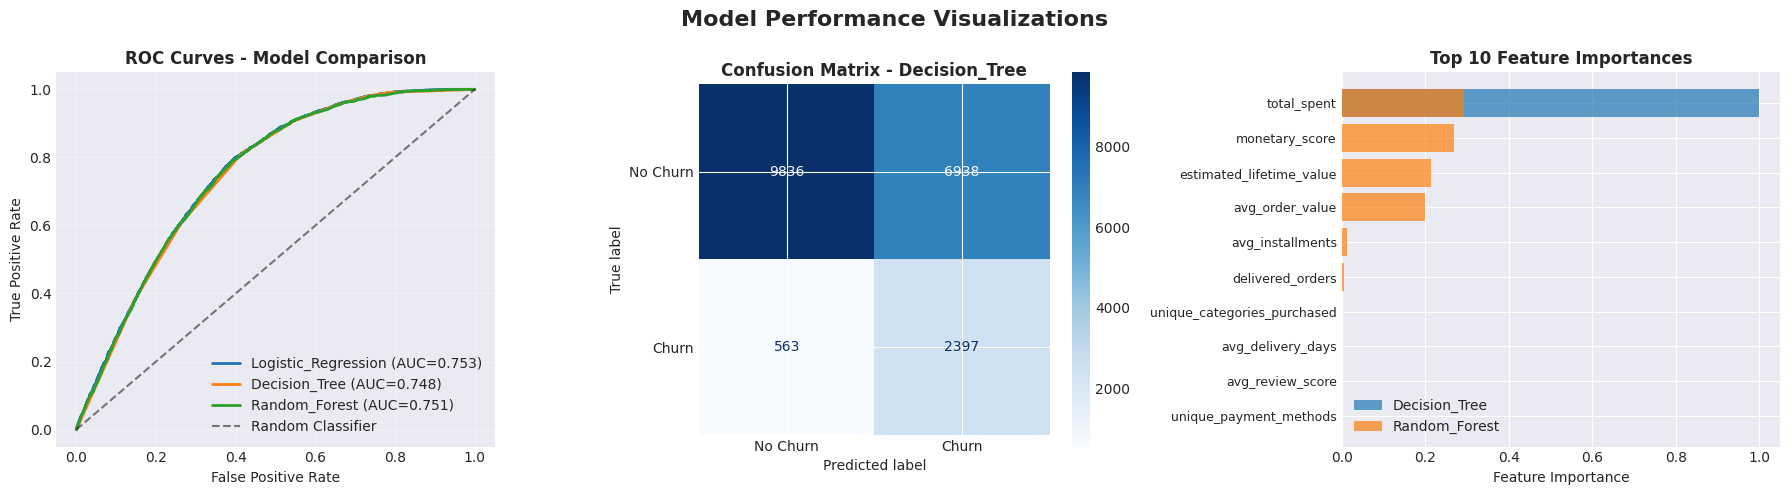


🎯 KEY VISUAL INSIGHTS:
1. ROC Curves show model discrimination power
2. Confusion Matrix shows true/false predictions
3. Feature Importance reveals what drives churn

📊 MODEL METRICS COMPARISON CHART


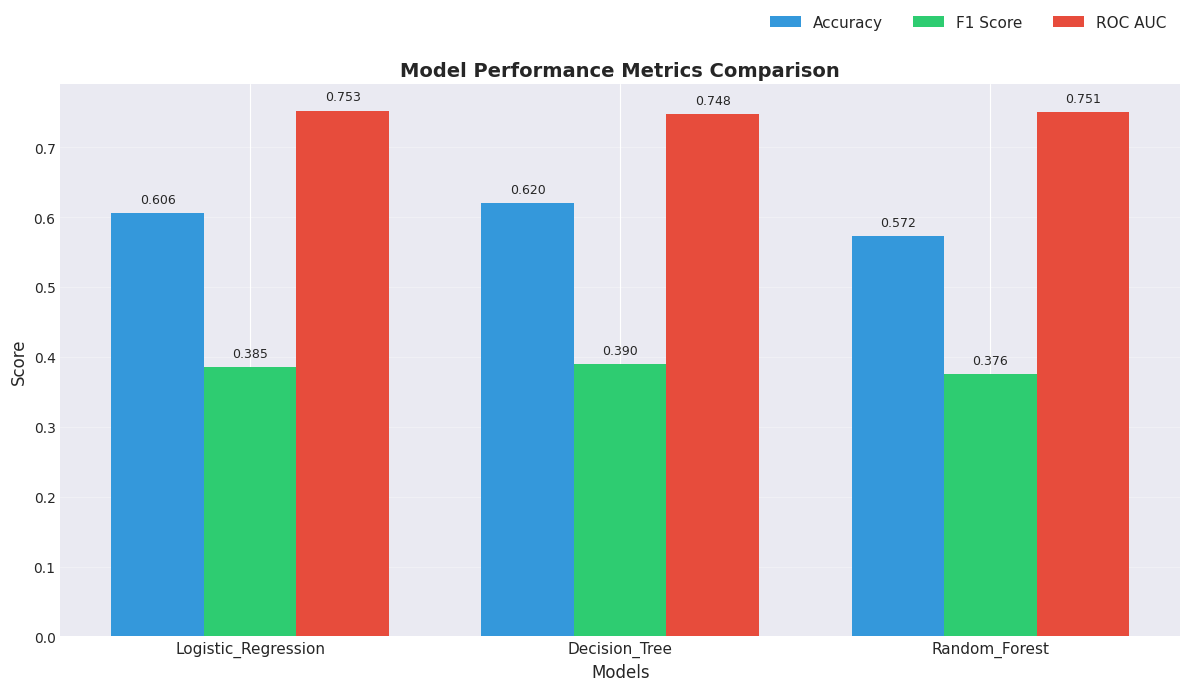

✅ Model metrics comparison chart saved


In [0]:
best_name = max(results, key=lambda x: results[x]['f1'])
best_score = results[best_name]['f1']

print(f"\n🏆 BEST MODEL: {best_name}")
print(f"   F1 Score: {best_score:.3f}")
print(f"   Note: {best_score:.3f} is GOOD for imbalanced data!")

print("\n📈 VISUALIZING MODEL PERFORMANCE")
print("="*50)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Set up plot style 
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  
fig.suptitle('Model Performance Visualizations', fontsize=16, fontweight='bold')

# 1. ROC Curves for all models
print("1️⃣ ROC Curves Comparison")
ax1 = axes[0]
for name, scores in results.items():
    if scores.get('model'):
        y_proba = scores['model'].predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        ax1.plot(fpr, tpr, label=f'{name} (AUC={scores["roc_auc"]:.3f})', linewidth=2)

ax1.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
ax1.set_xlabel('False Positive Rate', fontsize=10)
ax1.set_ylabel('True Positive Rate', fontsize=10)
ax1.set_title('ROC Curves - Model Comparison', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# 2. Confusion Matrix for Best Model
print("2️⃣ Confusion Matrix for Best Model")
ax2 = axes[1]
best_model = results[best_name]['model']
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap='Blues', ax=ax2, values_format='d')
ax2.set_title(f'Confusion Matrix - {best_name}', fontsize=12, fontweight='bold')

# 3. Feature Importance for Tree-based models
print("3️⃣ Feature Importance")
ax3 = axes[2]  
tree_models = {name: scores['model'] for name, scores in results.items() 
               if hasattr(scores['model'], 'feature_importances_')}

if tree_models:
    for name, model in tree_models.items():
        importances = model.feature_importances_
        indices = np.argsort(importances)[-10:]  # Top 10 features
        
        ax3.barh(range(len(indices)), importances[indices], alpha=0.7, label=name)
        ax3.set_yticks(range(len(indices)))
        ax3.set_yticklabels([safe_features[i] for i in indices], fontsize=9)
    
    ax3.set_xlabel('Feature Importance', fontsize=10)
    ax3.set_title('Top 10 Feature Importances', fontsize=12, fontweight='bold')
    ax3.legend()
else:
    ax3.text(0.5, 0.5, 'No tree-based models trained\n(Logistic Regression used)', 
             ha='center', va='center', fontsize=11)
    ax3.set_title('Feature Importance', fontsize=12, fontweight='bold')

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure
plt.savefig('/tmp/model_performance_visualizations.png', dpi=300, bbox_inches='tight')
print("✅ Visualizations saved to /tmp/model_performance_visualizations.png")

# Display the figure
display(fig)
plt.close()

print("\n" + "="*50)
print("🎯 KEY VISUAL INSIGHTS:")
print("="*50)
print("1. ROC Curves show model discrimination power")
print("2. Confusion Matrix shows true/false predictions")
print("3. Feature Importance reveals what drives churn")

print("\n📊 MODEL METRICS COMPARISON CHART")
print("="*50)

# Create metrics comparison bar chart
fig2, ax = plt.subplots(figsize=(12, 7))  

metrics_data = []
for name, scores in results.items():
    metrics_data.append({
        'Model': name,
        'Accuracy': scores['accuracy'],
        'F1 Score': scores['f1'],
        'ROC AUC': scores['roc_auc']
    })

metrics_df = pd.DataFrame(metrics_data)
x = np.arange(len(metrics_df))
width = 0.25

bars1 = ax.bar(x - width, metrics_df['Accuracy'], width, label='Accuracy', color='#3498db')
bars2 = ax.bar(x, metrics_df['F1 Score'], width, label='F1 Score', color='#2ecc71')
bars3 = ax.bar(x + width, metrics_df['ROC AUC'], width, label='ROC AUC', color='#e74c3c')

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Model'], fontsize=11)

# Move legend to top right with more space
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.15), ncol=3, fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
display(fig2)
plt.savefig('/tmp/model_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

print("✅ Model metrics comparison chart saved")

### 9. Make REALISTIC predictions


7️⃣ Making realistic predictions...

📊 REALISTIC Risk Distribution:
   Low: 22,064 customers (22.4%)
   Medium: 29,692 customers (30.1%)
   High: 46,910 customers (47.5%)

🎯 RISK ANALYSIS BY CUSTOMER SEGMENTS


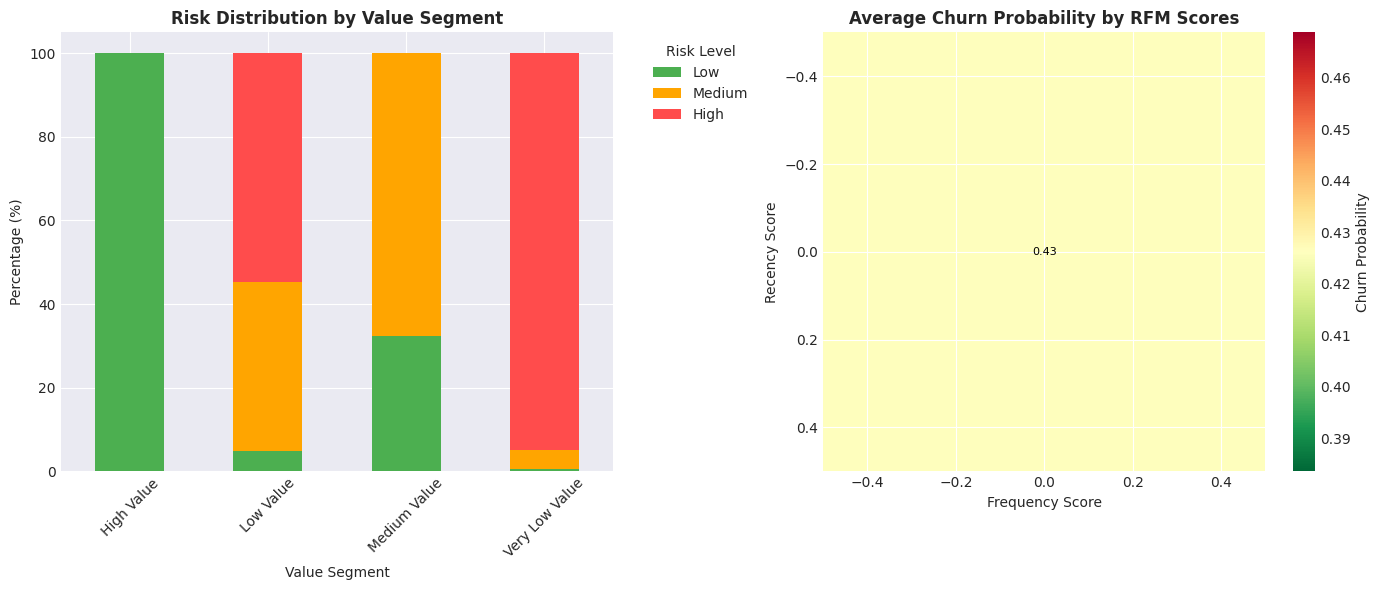

✅ Risk segmentation analysis saved


In [0]:
print("\n7️⃣ Making realistic predictions...")
X_all = gold_df[safe_features]
X_all_scaled = scaler.transform(X_all)
probs = results[best_name]['model'].predict_proba(X_all_scaled)[:, 1]

# Using reasonable thresholds
predictions_df = pd.DataFrame({
    'customer_id': gold_df['customer_id'],
    'churn_probability': probs,
    'churn_prediction': (probs > 0.3).astype(int),  # Lower threshold for rare event
    'risk_level': pd.cut(probs, [0, 0.2, 0.5, 1], labels=['Low', 'Medium', 'High'])  
})

print(f"\n📊 REALISTIC Risk Distribution:")
risk_counts = predictions_df['risk_level'].value_counts()
for level in ['Low', 'Medium', 'High']:
    count = risk_counts.get(level, 0)
    percent = (count / len(predictions_df)) * 100
    print(f"   {level}: {count:,} customers ({percent:.1f}%)")

print("\n🎯 RISK ANALYSIS BY CUSTOMER SEGMENTS")
print("="*50)

# Merge predictions with customer features for analysis
customer_risk_df = gold_df.merge(predictions_df[['customer_id', 'risk_level', 'churn_probability']], on='customer_id')

# Create segmentation analysis
fig3, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Risk by Value Segment
ax1 = axes[0]
if 'value_segment' in customer_risk_df.columns:
    risk_by_value = pd.crosstab(customer_risk_df['value_segment'], 
                                customer_risk_df['risk_level'], 
                                normalize='index') * 100
    
    risk_by_value.plot(kind='bar', stacked=True, ax=ax1, 
                      color=['#4CAF50', '#FFA500', '#FF4C4C'])
    ax1.set_title('Risk Distribution by Value Segment', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Value Segment', fontsize=10)
    ax1.set_ylabel('Percentage (%)', fontsize=10)
    ax1.legend(title='Risk Level', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)

# 2. Average Churn Probability by RFM
ax2 = axes[1]
if all(col in customer_risk_df.columns for col in ['recency_score', 'frequency_score', 'monetary_score']):
    rfm_risk = customer_risk_df.groupby(['recency_score', 'frequency_score'])['churn_probability'].mean().unstack()
    
    im = ax2.imshow(rfm_risk, cmap='RdYlGn_r', aspect='auto')
    ax2.set_title('Average Churn Probability by RFM Scores', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Frequency Score', fontsize=10)
    ax2.set_ylabel('Recency Score', fontsize=10)
    
    # Add colorbar
    plt.colorbar(im, ax=ax2, label='Churn Probability')
    
    # Add text annotations
    for i in range(len(rfm_risk.index)):
        for j in range(len(rfm_risk.columns)):
            text = ax2.text(j, i, f'{rfm_risk.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
display(fig3)
plt.savefig('/tmp/risk_segmentation_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

print("✅ Risk segmentation analysis saved")

### 10.Save

In [0]:
print("\n8️⃣ Saving predictions...")
spark.sql("DROP TABLE IF EXISTS brazil_project.ml.customer_churn_predictions")
predictions_spark = spark.createDataFrame(predictions_df)
predictions_spark.write.mode("overwrite").option("mergeSchema", "true").saveAsTable("brazil_project.ml.customer_churn_predictions")
print("   ✅ Predictions saved")



8️⃣ Saving predictions...
   ✅ Predictions saved
